In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

# Tensorboard

In [2]:
%tensorboard --logdir=reports/simple_cnn_batchnorm2d_cifar10_sgd_fp_traces

In [1]:
import torch
from torch.autograd import Variable

def max_eigenvalue(model, loss_fn, data, target):
    # Set model to evaluation mode
    model.eval()
    # Create a variable from the data
    data = Variable(data, requires_grad=True)
    # Compute the loss
    loss = loss_fn(model(data), target)
    # Compute the gradients
    loss.backward(create_graph=True)
    # Get the gradients of the weights
    grads = torch.cat([p.grad.view(-1) for p in model.parameters()])
    # Create a vector of ones with the same size as the gradients
    v = torch.ones(grads.size())
    # Compute the Hessian-vector product
    Hv = torch.autograd.grad(grads, model.parameters(), grad_outputs=v, retain_graph=True)
    # Concatenate the Hessian-vector product into a single vector
    Hv = torch.cat([h.view(-1) for h in Hv])
    # Compute the maximum eigenvalue using the power iteration method
    for _ in range(100):
        v = Hv / torch.norm(Hv)
        Hv = torch.autograd.grad(grads, model.parameters(), grad_outputs=v, retain_graph=True)
        Hv = torch.cat([h.view(-1) for h in Hv])
    return (v * Hv).sum()

In [8]:
import torch
from torch.autograd import Variable

def max_eigenvalue(model, loss_fn, data, target):
    # Set model to evaluation mode
    model.eval()
    # Create a variable from the data
    data = torch.autograd.Variable(data, requires_grad=True)
    # Compute the loss
    loss = loss_fn(model(data), target)
    # Compute the gradients
    grads = torch.autograd.grad(
            loss,
            [p for p in model.parameters() if p.requires_grad],
            retain_graph=True,
            create_graph=True)
    # Get the gradients of the weights
    grads = torch.cat([g.reshape(-1) for g in grads])
    print(grads.size())
    # Create a vector of ones with the same size as the gradients
    v = torch.ones(grads.size())#.to(grads.device)
    # Compute the Hessian-vector product
    Hv = torch.autograd.grad(grads, [p for p in model.parameters() if p.requires_grad], grad_outputs=v, retain_graph=True)
    # Concatenate the Hessian-vector product into a single vector
    Hv = torch.cat([h.reshape(-1) for h in Hv])
    # Compute the maximum eigenvalue using the power iteration method
    for _ in range(100):
        v = Hv / torch.norm(Hv)
        Hv = torch.autograd.grad(grads, model.parameters(), grad_outputs=v, retain_graph=True)
        Hv = torch.cat([h.reshape(-1) for h in Hv])

    return (v * Hv).sum()

# correct this code to get rid of the error RuntimeError: reshape size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.
def max_eigenvalue_corrected(model, loss_fn, data, target):
    # Set model to evaluation mode
    model.eval()
    # Create a variable from the data
    data = torch.autograd.Variable(data, requires_grad=True)
    # Compute the loss
    loss = loss_fn(model(data), target)
    # Compute the gradients
    grads = torch.autograd.grad(
            loss,
            [p for p in model.parameters() if p.requires_grad],
            retain_graph=True,
            create_graph=True)
    # Get the gradients of the weights
    grads = torch.cat([g.reshape(-1) for g in grads])
    # Create a vector of ones with the same size as the gradients
    v = torch.ones(grads.size()).to(grads.device)
    # Compute the Hessian-vector product
    Hv = torch.autograd.grad(grads, [p for p in model.parameters() if p.requires_grad], grad_outputs=v, retain_graph=True)
    # Concatenate the Hessian-vector product into a single vector
    Hv = torch.cat([h.reshape(-1) for h in Hv])
    # Compute the maximum eigenvalue using the power iteration method
    for _ in range(100):
        v = Hv / torch.norm(Hv)
        Hv = torch.autograd.grad(grads, model.parameters(), grad_outputs=v, retain_graph=True)
        Hv = torch.cat([h.reshape(-1) for h in Hv])

    return (v * Hv).sum()

In [1]:
import torch
from typing import List, Dict, Any

class SimpleCNN(torch.nn.Module):
    def __init__(self, layers_dim: List[int]):
        super().__init__()
        self.blocks = torch.nn.ModuleList([
            torch.nn.Sequential(torch.nn.Conv2d(layer_dim1, layer_dim2, 3, padding=1),
                                torch.nn.ReLU(),
                                torch.nn.Conv2d(layer_dim2, layer_dim2, 3, padding=1, stride=2),
                                torch.nn.ReLU(),
                                # torch.nn.MaxPool2d(2, 2)
                                )
            for layer_dim1, layer_dim2 in zip(layers_dim[:-3], layers_dim[1:-2])
        ])
        # flatten_dim = infer_flatten_dim(conv_params, layers_dim[-3])
        # napisz wnioskowanie spłaszczonego wymiaru
        self.final_layer = torch.nn.Sequential(torch.nn.Linear(4096, layers_dim[-2]), torch.nn.ReLU(),
                                               torch.nn.Linear(layers_dim[-2], layers_dim[-1]))

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = x.flatten(start_dim=1)
        x = self.final_layer(x)
        return x
    

class MLP(torch.nn.Module):
    def __init__(self, layers_dim):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Sequential(torch.nn.Linear(hidden_dim1, hidden_dim2), torch.nn.ReLU())
            for hidden_dim1, hidden_dim2 in zip(layers_dim[:-2], layers_dim[1:-1])
        ])
        self.final_layer = torch.nn.Linear(layers_dim[-2], layers_dim[-1])

    def forward(self, x):
        x = x.flatten(start_dim=1)
        for layer in self.layers:
            x = layer(x)
        x = self.final_layer(x)
        return x

In [2]:
model = SimpleCNN([3, 32, 64, 128, 10])
model

SimpleCNN(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
    )
  )
  (final_layer): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [4]:
model = SimpleCNN([3, 32, 64, 128, 10])
model

SimpleCNN(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
    )
  )
  (final_layer): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
import os

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root=os.environ['CIFAR10_PATH'], train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

model = SimpleCNN([3, 32, 64, 128, 10])
optim = torch.optim.SGD(model.parameters(), lr=0.01)

x_true, y_true = next(iter(trainloader))

criterion = torch.nn.CrossEntropyLoss()


Files already downloaded and verified


In [9]:
# optim.zero_grad()
max_eigenvalue_corrected(model, criterion, x_true, y_true)

tensor(0.4235)

In [7]:
for p in model.parameters():
    print(p.grad.shape)

torch.Size([10, 100])
torch.Size([10])


Brurrin images

In [6]:
import os

import torch
import torchvision
import torchvision.transforms as transforms

Normal

In [41]:
mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262)
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomAffine(degrees=0, translate=(1/8, 1/8)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean, std),
    ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root=os.environ['CIFAR10_PATH'], train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


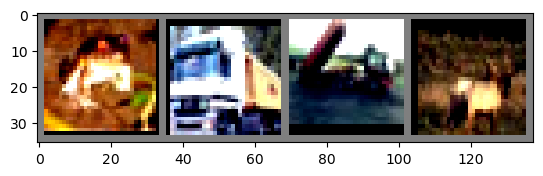

frog  truck truck deer 


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Blurred

In [45]:
from torchvision.transforms import InterpolationMode
down_to = 16
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(down_to, interpolation=InterpolationMode.BILINEAR, antialias=None),
        transforms.Resize(32, interpolation=InterpolationMode.BILINEAR, antialias=None), 
        transforms.RandomAffine(degrees=0, translate=(1/8, 1/8)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean, std),
    ])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(down_to, interpolation=InterpolationMode.BILINEAR, antialias=True), transforms.Resize(32, interpolation=InterpolationMode.BILINEAR, antialias=True), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root=os.environ['CIFAR10_PATH'], train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


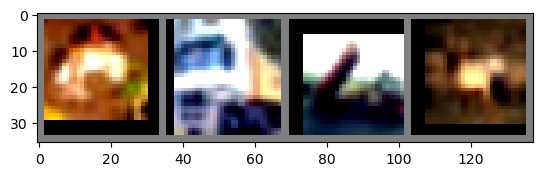

frog  truck truck deer 


In [46]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))